In [2]:
import pandas as pd

In [17]:
dec= pd.read_csv("2019-Dec.csv",index_col=None)
print(dec.shape)
oc=pd.read_csv("2019-Oct.csv",index_col=None)
print(oc.shape)
nv=pd.read_csv("2019-Nov.csv",index_col=None)
print(nv.shape)
jan=pd.read_csv("2020-Jan.csv",index_col=None)
print(jan.shape)
feb=pd.read_csv("2020-Feb.csv",index_col=None)
print(feb.shape)

(3533286, 9)
(4102283, 9)
(4635837, 9)
(4264752, 9)
(4156682, 9)


In [49]:
data = pd.concat([oc,nv,dec,jan,feb]).reset_index(drop=True)
data=data.rename(columns={"user_session":"Session_id",})
data.shape

(3533286, 9)

In [50]:
data['col1']=1

In [51]:
df=data[['user_id','col1']].groupby('user_id').count().reset_index().sort_values(by='col1').rename(columns={'col1':'occ_user'})

In [52]:
#df

In [53]:
dic={}
for occ in list(df['occ_user'].unique()):
    dic[occ]= len(list(df[df['occ_user']==occ]['user_id']))

In [54]:
import random

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [55]:
Partitions=[]

In [56]:
#user_id avec une occurrence > 1000 : un consumer_id a un seul compte
Partitions=list(df[df['occ_user']>1000]['user_id'].apply(lambda x : [x]))

In [57]:
users_with_occ_moy = list(df.query(f'occ_user > 100 and occ_user < 1000')['user_id'])
Partitions+=list(chunks(users_with_occ_moy,2))
print(len(Partitions))

3144


In [58]:
users_with_occ_f = list(df.query(f'occ_user > 2 and occ_user < 100')['user_id'])
Partitions+=list(chunks(users_with_occ_f,3))
print(len(Partitions))

45478


In [59]:
import random
from random import randrange
import numpy
users_with_occ_unitaire = list(df.query(f'occ_user == 1')['user_id'])
i=0
while i==0  or i< 200:
    i=randrange(500)

for el in list(chunks(users_with_occ_unitaire,i)):
    d=0
    while d<=0 or d>i:
        d=int(random.gauss(10,50))

    Partitions+=list(chunks(el,d))
len(Partitions)


56592

In [60]:
consumers={}
for el in Partitions:
    consumer = str(el[0]) +'_'+str(random.getrandbits(20))
    for elm in el:
        consumers[elm] = consumer

    

In [61]:
data['Customer_id']= data['user_id'].map(consumers)

In [62]:
nb_user_per_cos= data[['Customer_id','user_id']].groupby('Customer_id').nunique().reset_index().rename(columns={"user_id":'nb_user_per_cos'})
nb_cos_per_nb_user= nb_user_per_cos.groupby('nb_user_per_cos').nunique().reset_index().rename(columns={"Customer_id":'nb_cos_per_nb_user'})

In [63]:
nb_cos_per_nb_user

,nb_user_per_cos,nb_cos_per_nb_user
0,1,2007
1,2,3928
2,3,43089
3,4,468
4,5,656
...,...,...
119,151,3
120,153,1
121,160,2
122,171,1


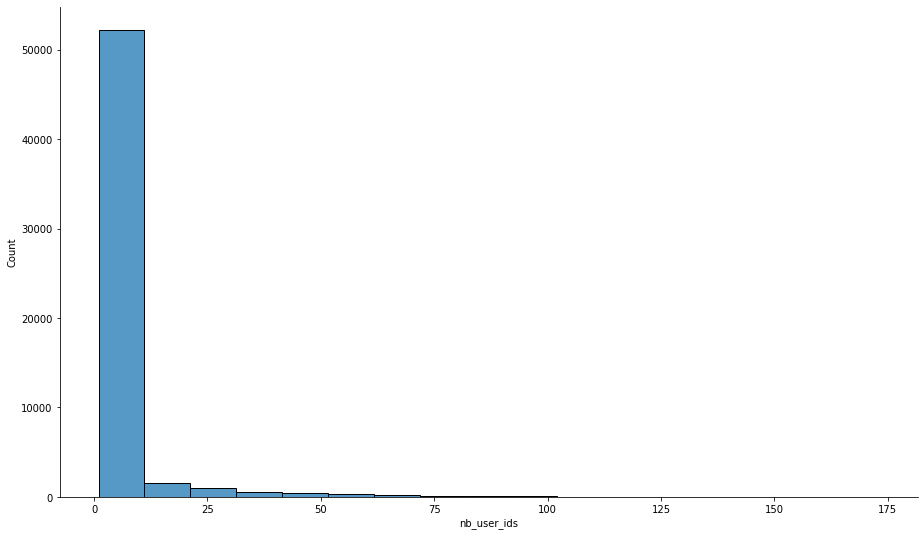

In [64]:
import seaborn as sns
g = sns.displot(data=data[['Customer_id','user_id']].groupby('Customer_id').nunique().reset_index().rename(columns={"user_id":"nb_user_ids"}), x="nb_user_ids", multiple="stack")

g.fig.set_size_inches(15,8)

In [65]:
#data[data['Consumer_id']=='510623624_381213']

In [66]:
data[['Customer_id','Session_id']].groupby('Customer_id').count().reset_index().groupby('Session_id').count().reset_index().rename(columns={"Session_id":"nb_sessions_per_Costmer","Customer_id":"nb_constumer"})


,nb_sessions_per_Costmer,nb_constumer
0,1,1957
1,2,833
2,3,756
3,4,470
4,5,655
...,...,...
841,2356,1
842,2426,1
843,3147,1
844,3883,1


<function matplotlib.pyplot.show(close=None, block=None)>

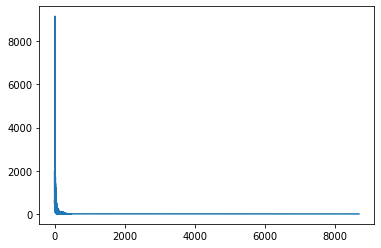

In [67]:
import matplotlib.pyplot as plt
a= data[['Customer_id','Session_id']].groupby('Customer_id').count().reset_index().groupby('Session_id').count().reset_index().rename(columns={"Session_id":"nb_sessions_per_Costmer","Customer_id":"nb_constumer"})


x= list(a['nb_sessions_per_Costmer'])
y= list(a['nb_constumer'])

plt.plot(x,y)
plt.show

In [68]:
worldcities=pd.read_csv('worldcities.csv')[['city','country','lat','lng']]
dict_cities={}
import json
result = worldcities[['city','lat','lng']].to_json(orient="values")
parsed = json.loads(result)
for el in parsed:
    dict_cities[el[0]]= [el[1], el[2]]


In [69]:
worldcities[['country','lat','lng']].groupby('country').agg(['min','max'])

lat                lng          
                    min      max       min       max
country                                             
Afghanistan     30.9600  37.1298   61.8600   71.1528
Albania         39.8833  42.3582   19.4500   20.9900
Algeria         19.5686  36.9167   -8.1286    9.5500
American Samoa -14.2740 -14.2740 -170.7046 -170.7046
Andorra         42.4664  42.5670    1.4933    1.5981
...                 ...      ...       ...       ...
West Bank       31.7764  31.7764   35.2269   35.2269
Western Sahara  26.0928  26.0928  -10.6089  -10.6089
Yemen           12.6519  16.9358   42.9511   54.0239
Zambia         -17.8500  -8.8400   22.6800   33.1700
Zimbabwe       -22.2167 -16.5333   25.8333   32.6694

[237 rows x 4 columns]

In [70]:
from random import randrange
dic_location={}
cities=list(worldcities['city'].unique())
for el in list(data['Session_id'].unique()):
    i= randrange(len(cities))
    lat=randrange(5)
    lng=randrange(5)
    dic_location[el] = [float(dict_cities[cities[i]][0])+lat, float(dict_cities[cities[i]][1])+lng]
    

In [71]:
data['Location']=data['Session_id'].map(dic_location)

In [72]:
import numpy as np
part1= data.sample(frac = 0.8)
part2 = data.drop(part1.index)
print(part1.shape)
part1['License_id']= part1['product_id']
part2['License_id']= np.random.randint(1, 10000, part2.shape[0])

data=pd.concat([part1,part2])
print(data.shape)

(2826629, 12)
(3533286, 13)


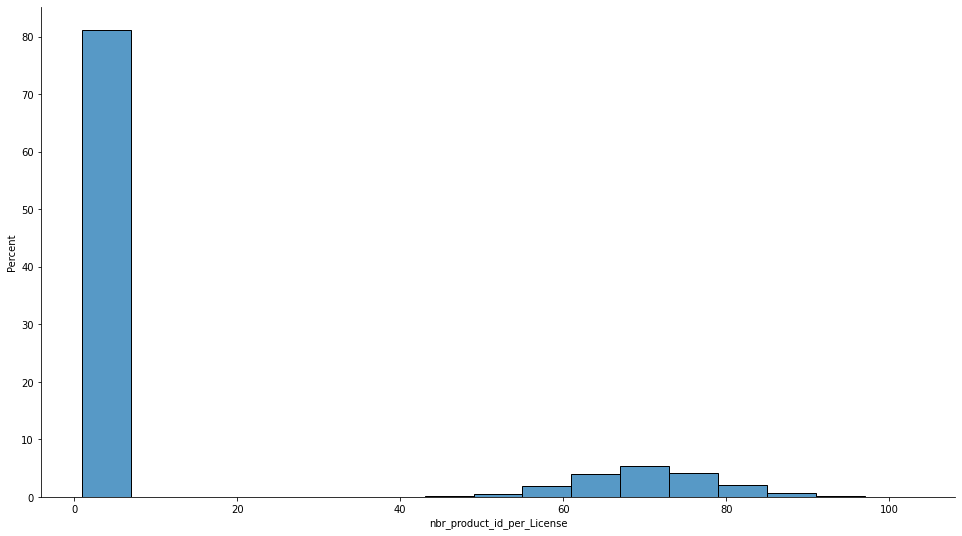

In [73]:
import seaborn as sns
g = sns.displot(data=data[['License_id','product_id']].groupby('License_id').nunique().reset_index().rename(columns={"product_id":"nbr_product_id_per_License"}), x="nbr_product_id_per_License", stat='percent',multiple="stack")

g.fig.set_size_inches(15,8)

In [74]:
import datetime
from random import randrange
from datetime import timedelta
def start_event(event):
    h=randrange(10)
    m=randrange(60)
    return event-timedelta(hours=h, minutes= m)

def end_event(event):
    h=randrange(10)
    m=randrange(60)   
    return event+timedelta(hours=h, minutes= m)
    

In [75]:

data['event_time']=data['event_time'].apply(lambda x : datetime.datetime.strptime(str(x)[:-4],"%Y-%m-%d %H:%M:%S"))


In [76]:
data['Session_start_datetime']= data['event_time'].apply(lambda x : start_event(x))
data['Session_end_datetime']= data['event_time'].apply(lambda x : end_event(x))

In [77]:
data['duration']=data['Session_end_datetime'] - data['Session_start_datetime']


In [ ]:
data['duration']=data['duration'].apply(lambda x : x.total_seconds()/60)

In [44]:
import seaborn as sns
g = sns.displot(data=data, x="duration", stat='percent',multiple="stack")

g.fig.set_size_inches(15,8)

In [80]:
df=data[['License_id','Session_start_datetime','Session_end_datetime','col1']].groupby('License_id').agg({'Session_start_datetime' : 'min', 'Session_end_datetime' : 'max','col1':'count'}).reset_index()
df=df.rename(columns={"Session_start_datetime":"License_start_date","Session_end_datetime": "License_end_date"})

In [89]:
res= pd.merge(data,df[['License_id','License_start_date','License_end_date']], on= 'License_id')
res=res.drop(columns='col1')
res

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,Session_id,Customer_id,Location,License_id,Session_start_datetime,Session_end_datetime,duration,License_start_date,License_end_date
0,2019-12-05 04:52:37,cart,3978,1487580005411062629,NaN,cnd,29.05,511177493,6fe1f442-24eb-4461-ba47-5a484fab0770,584747065_193818,"[-22.1808, -49.6469]",3978,2019-12-05 01:33:37,2019-12-05 07:35:37,0 days 06:02:00,2019-11-30 15:17:26,2020-01-01 02:10:57
1,2019-12-14 20:33:44,remove_from_cart,3978,1487580005411062629,NaN,cnd,29.05,586431007,7eaae0f5-075b-4d95-861f-4a98b308e372,534475968_744114,"[51.1167, 15.8667]",3978,2019-12-14 13:49:44,2019-12-15 03:56:44,0 days 14:07:00,2019-11-30 15:17:26,2020-01-01 02:10:57
2,2019-12-08 21:43:52,view,3978,1487580005411062629,NaN,cnd,29.05,518846352,90abb6b7-13c2-409e-bb83-a1b7d0316eef,571738090_788463,"[36.2236, -5.127800000000001]",3978,2019-12-08 14:05:52,2019-12-09 03:44:52,0 days 13:39:00,2019-11-30 15:17:26,2020-01-01 02:10:57
3,2019-12-31 10:58:02,view,3978,1487580005411062629,NaN,cnd,29.05,570294690,2367c353-fb70-41af-a7ca-c0b0ff96ff33,557802240_283271,"[11.9281, -68.5778]",3978,2019-12-31 02:55:02,2019-12-31 15:45:02,0 days 12:50:00,2019-11-30 15:17:26,2020-01-01 02:10:57
4,2019-12-12 16:34:09,cart,3978,1487580005411062629,NaN,cnd,29.05,465503484,dc7c3e53-d30d-4892-9561-2e131f3622c0,465503484_510336,"[10.7903, -72.7556]",3978,2019-12-12 07:01:09,2019-12-12 21:45:09,0 days 14:44:00,2019-11-30 15:17:26,2020-01-01 02:10:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3533281,2019-12-27 13:12:49,cart,5697499,1487580013841613016,NaN,estel,6.59,593430267,1e35cf65-2200-4563-8903-5117b8ecb0d8,593430267_252984,"[35.1713, -82.9142]",4861,2019-12-27 04:08:49,2019-12-27 16:16:49,0 days 12:08:00,2019-12-04 23:55:30,2019-12-29 05:24:14
3533282,2019-12-27 20:25:06,view,5897535,1487580009311764506,NaN,NaN,2.16,583884978,3a137aaa-868f-4f1a-a62e-b2813e18a10d,583884978_428750,"[14.4333, 124.5167]",4861,2019-12-27 16:31:06,2019-12-28 00:32:06,0 days 08:01:00,2019-12-04 23:55:30,2019-12-29 05:24:14
3533283,2019-12-28 05:42:20,view,5790562,1487580011585077370,NaN,NaN,38.10,196042408,5b697e1f-cfbb-4a14-9b53-dc76a34d38eb,556265124_820671,"[38.8, 36.53]",4861,2019-12-28 04:00:20,2019-12-28 15:36:20,0 days 11:36:00,2019-12-04 23:55:30,2019-12-29 05:24:14
3533284,2019-12-28 21:16:14,view,5717245,1487580008145748965,NaN,NaN,0.95,571141506,64f7d0d6-8726-4902-aa1f-1b2bfdd95809,564341737_140932,"[39.15, -2.9667]",4861,2019-12-28 16:19:14,2019-12-29 05:24:14,0 days 13:05:00,2019-12-04 23:55:30,2019-12-29 05:24:14


In [88]:
list(res.columns)

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'Session_id',
 'Customer_id',
 'Location',
 'License_id',
 'Session_start_datetime',
 'Session_end_datetime',
 'duration',
 'License_start_date',
 'License_end_date']

In [15]:
res.to_csv('data_out.csv',index=False)

# Graph

In [141]:
#import networkx as nx
#G = nx.Graph()

In [84]:
#columns=list(data.columns)
#for el in ['event_time','col1','duration']:
    #columns.remove(el)
#print(columns)

In [ ]:
#G = nx.from_pandas_edgelist(data, 'event_type', 'product_id')

In [ ]:
#from matplotlib.pyplot import figure
#figure(figsize=(100, 80))
#nx.draw_shell(G, with_labels=True)

In [191]:
#G = nx.from_numpy_matrix(data.values)
#G = nx.relabel_nodes(G, dict(enumerate(data.columns)))
# nx.draw_spectral(G)
# nx.draw_random(G)
# nx.draw_circular(G)
#nx.draw(G)

In [204]:
#df = pd.read_csv('2019-Dec_out.csv')

In [2]:
#import torch
#
#def load_node_csv(path, index_col, columns,encoders=None, **kwargs):
#    df = pd.read_csv(path, index_col=index_col, **kwargs)[columns]
#    mapping = {index: i for i, index in enumerate(df.index.unique())}
#
#    x = None
#    if encoders is not None:
#        xs = [encoder(df[col]) for col, encoder in encoders.items()]
#        x = torch.cat(xs, dim=-1)
#
#    return x, mapping

In [47]:
#Session= data[['user_session','start_event','event_type','end_event','product_id','user_id','Consumer_id']]
#Product=data[['product_id','category_id','category_code','brand','price']]
#License=data[['License_id','Consumer_id','product_id']]
#Customer= data[['Consumer_id','Location']]

In [12]:
#a.to_csv('test.csv',index=False)

In [13]:
#session_x, session_mapping = load_node_csv('2019-Dec_out.csv', index_col='user_session',columns=['user_session','start_event','event_type','end_event','product_id','user_id','Consumer_id'])

In [14]:
#product_x, product_mapping = load_node_csv('2019-Dec_out.csv', index_col='product_id',columns=['product_id','category_id','category_code','brand','price'])

In [ ]:
#user_x, user_mapping = load_node_csv('2019-Dec_out.csv', index_col='user_id',columns=['License_id','Consumer_id','product_id'])

In [ ]:
#user_x, user_mapping = load_node_csv('2019-Dec_out.csv', index_col='user_id',columns=['License_id','Consumer_id','product_id'])

In [ ]:
#from torch_geometric.data import HeteroData
#
#data = HeteroData()
#
#data['user'].num_nodes = len(user_mapping)  # Users do not have any features.
#data['movie'].x = movie_x
#
#print(data)
#HeteroData(
#  user={ num_nodes=610 },
#  movie={ x[9742, 404] }
#)

In [ ]:
#def load_edge_csv(path, src_index_col, src_mapping, dst_index_col, dst_mapping,
#                  encoders=None, **kwargs):
#    df = pd.read_csv(path, **kwargs)
#
#    src = [src_mapping[index] for index in df[src_index_col]]
#    dst = [dst_mapping[index] for index in df[dst_index_col]]
#    edge_index = torch.tensor([src, dst])
#
#    edge_attr = None
#    if encoders is not None:
#        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
#        edge_attr = torch.cat(edge_attrs, dim=-1)
#
#    return edge_index, edge_attr

In [ ]:
#class IdentityEncoder(object):
#    def __init__(self, dtype=None):
#        self.dtype = dtype
#
#    def __call__(self, df):
#        return torch.from_numpy(df.values).view(-1, 1).to(self.dtype)

In [ ]:
#edge_index, edge_label = load_edge_csv(
#    rating_path,
#    src_index_col='userId',
#    src_mapping=user_mapping,
#    dst_index_col='movieId',
#    dst_mapping=movie_mapping,
#    encoders={'rating': IdentityEncoder(dtype=torch.long)},
#)
#
#data['user', 'rates', 'movie'].edge_index = edge_index
#data['user', 'rates', 'movie'].edge_label = edge_label
#
#print(data)
#HeteroData(
#  user={ num_nodes=610 },
#  movie={ x=[9742, 404] },
#  (user, rates, movie)={
#    edge_index=[2, 100836],
#    edge_label=[100836, 1]
#  }
#)